## Final Model Comparison: 2026 Box Office Prediction

In [1]:
# Setup and imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys

_NOTEBOOK_DIR = Path().resolve()
_candidate_paths = [
    _NOTEBOOK_DIR,
    _NOTEBOOK_DIR / 'code',
    _NOTEBOOK_DIR.parent,
    _NOTEBOOK_DIR.parent / 'code',
]

for _candidate in _candidate_paths:
    if (_candidate / 'model_utils.py').exists():
        sys.path.insert(0, str(_candidate))
        break

from model_utils import (
    DEFAULT_EXCLUDE_COLS,
    prepare_features,
    evaluate_model,
    get_top10_predictions,
    create_sample_weights,
    log_results_to_mlflow,
    calculate_top_k_overlap,
    compute_ranking_metrics,   # ← add this
)



from IPython.display import display

# MLflow tracking setup
try:
    import mlflow
    MLFLOW_AVAILABLE = True
except ImportError:
    mlflow = None
    MLFLOW_AVAILABLE = False
    print("⚠️  MLflow not installed; skipping experiment history.")
else:
    MLFLOW_TRACKING_DIR = (_NOTEBOOK_DIR.parent / 'mlruns').resolve()
    mlflow.set_tracking_uri(f"file://{MLFLOW_TRACKING_DIR}")
    mlflow.set_experiment("box_office_modeling")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("🎬 Box Office Prediction: Final Model Comparison")
print("Using best trained models from experimentation (notebook 4)")


🎬 Box Office Prediction: Final Model Comparison
Using best trained models from experimentation (notebook 4)


In [2]:

# Load modeling dataset (filtered in notebook 4 if applicable)
filtered_path = Path('../data/dataset_domestic_processed_modeling.csv')
base_path = Path('../data/dataset_domestic_processed.csv')

if filtered_path.exists():
    df = pd.read_csv(filtered_path)
    print(f"📁 Loaded modeling-scoped dataset: {filtered_path} ({len(df):,} rows)")
else:
    df = pd.read_csv(base_path)
    print(f"📁 Loaded full processed dataset: {base_path} ({len(df):,} rows)")

scope_config_path = Path('../data/dataset_scope.json')
if scope_config_path.exists():
    try:
        DATA_SCOPE = json.loads(scope_config_path.read_text())
        print(f"🔎 Using scope configuration from {scope_config_path.name}: {DATA_SCOPE}")
    except json.JSONDecodeError:
        DATA_SCOPE = {}
        print('⚠️ Could not parse dataset_scope.json; proceeding without scope metadata.')
else:
    DATA_SCOPE = {}

print(f"Date range: {df['release_year'].min()}-{df['release_year'].max()}")
print(f"Revenue range: ${df['revenue_domestic'].min():,.0f} - ${df['revenue_domestic'].max():,.0f}")
print(f"Average revenue: ${df['revenue_domestic'].mean():,.0f}")


📊 Loading and Preparing Data
Dataset loaded: 1416 movies, 94 features
Date range: 2015-2025
Revenue range: $521,202 - $936,662,225


In [3]:

scope_note_major = DATA_SCOPE.get('studio_note', 'all studios')
scope_note_lang = DATA_SCOPE.get('language_note', 'all languages')
print("🎯 Strategic Focus: Modeling Scope")
print("=" * 60)
print(f"   • Studio scope: {scope_note_major}")
print(f"   • Language scope: {scope_note_lang}")

# Prepare feature list via shared helper (scoped dataset delivered from notebook 4)
print("=" * 60)

original_row_count = len(df)

df, feature_cols, target = prepare_features(
    df,
    exclude_cols=DEFAULT_EXCLUDE_COLS,
    filter_major_only=False,
    drop_major_flag_from_features=False,
    verbose=True,
)

major_share = df['is_major_studio'].mean() if 'is_major_studio' in df.columns else float('nan')
print(f"Total rows retained: {len(df):,} (of {original_row_count:,})")
if not np.isnan(major_share):
    print(f"   • Major studios: {int(df['is_major_studio'].sum()):,} ({major_share*100:.1f}%)")
print(f"Target variable: {target}")


🎯 Strategic Focus: Full Dataset with Major-Studio Indicator

🔧 Feature preparation summary:
   • Candidate features: 64
   • Columns with missing values:
     – days_to_holiday: 736 nulls
Total rows retained: 1,416 (of 1,416)
   • Major studios: 821 (58.0%)
Target variable: revenue_domestic


In [4]:
# Prepare training and validation data
print("📚 Preparing Training and Validation Data")
print("=" * 50)

# Split data by years (temporal validation)
train_data = df[df['release_year'].between(2015, 2023)].copy()
val_data = df[df['release_year'] == 2024].copy()
test_data = df[df['release_year'] == 2025].copy()

print(f"Data splits:")
print(f"   • Training (2015-2023): {len(train_data)} movies")
print(f"   • Validation (2024): {len(val_data)} movies")
print(f"   • Test (2025): {len(test_data)} movies")

# Create sample weights (best strategy from experimentation: weighted pandemic)
sample_weights = create_sample_weights(train_data)
pandemic_count = int(train_data['is_pandemic_year'].sum()) if 'is_pandemic_year' in train_data.columns else 0

print("Sample weighting:")
print(f"   • Normal years: 1.0 weight")
print(f"   • Pandemic years (2020-2021): 0.3 weight ({pandemic_count} movies)")

# Prepare feature matrices
X_train = train_data[feature_cols]
y_train = train_data[target]
y_train_log = np.log1p(y_train)  # Log transform for better model performance

X_val = val_data[feature_cols]
y_val = val_data[target]
y_val_log = np.log1p(y_val)

print("Feature matrices prepared:")
print(f"   • Training: {X_train.shape}")
print(f"   • Validation: {X_val.shape}")
print(f"   • Log-transformed target for better model performance")


📚 Preparing Training and Validation Data
Data splits:
   • Training (2015-2023): 1145 movies
   • Validation (2024): 159 movies
   • Test (2025): 112 movies
Sample weighting:
   • Normal years: 1.0 weight
   • Pandemic years (2020-2021): 0.3 weight (149 movies)
Feature matrices prepared:
   • Training: (1145, 64)
   • Validation: (159, 64)
   • Log-transformed target for better model performance


## Model 1: Ridge Regression

Linear model with L2 regularization. Good baseline with interpretable coefficients.

## Model 2: Decision Tree

Non-linear model that can capture feature interactions and thresholds.

## Model 3: Random Forest

Ensemble of decision trees for improved generalization and reduced overfitting.

## Model Comparison & Selection

In [8]:

# Summarise MLflow runs (best to worst)
print("🏆 Final Model Comparison")
print("=" * 50)

if not available_results:
    print("⚠️ No MLflow runs available. Run notebook 4 to log experiments before executing this summary.")
else:
    rows = []
    for result in available_results:
        rmse_val = result.get('rmse')
        if rmse_val is None or pd.isna(rmse_val):
            continue
        rows.append({
            'Model': result.get('model_name', 'MLflow run'),
            'RMSE_raw': rmse_val,
            'MAE_raw': result.get('mae'),
            'MAPE_raw': result.get('mape'),
            'R2_raw': result.get('r2'),
            'RMSE': f"${rmse_val:,.0f}",
            'MAE': f"${result['mae']:,.0f}" if result.get('mae') is not None and not pd.isna(result['mae']) else 'n/a',
            'MAPE': f"{result['mape']:.1f}%" if result.get('mape') is not None and not pd.isna(result['mape']) else 'n/a',
            'R²': f"{result['r2']:.3f}" if result.get('r2') is not None and not pd.isna(result['r2']) else 'n/a',
            'Recall@10': f"{result['recall_at_10']:.2%}" if result.get('recall_at_10') is not None and not pd.isna(result['recall_at_10']) else 'n/a',
            'Precision@10': f"{result['precision_at_10']:.2%}" if result.get('precision_at_10') is not None and not pd.isna(result['precision_at_10']) else 'n/a',
            'NDCG@10': f"{result['ndcg_at_10']:.3f}" if result.get('ndcg_at_10') is not None and not pd.isna(result['ndcg_at_10']) else 'n/a',
            'Spearman': f"{result['spearman_corr']:.3f}" if result.get('spearman_corr') is not None and not pd.isna(result['spearman_corr']) else 'n/a',
            'Kendall': f"{result['kendall_corr']:.3f}" if result.get('kendall_corr') is not None and not pd.isna(result['kendall_corr']) else 'n/a'
        })

    if not rows:
        print("⚠️ MLflow runs found, but all lack RMSE values.")
    else:
        comparison_df = pd.DataFrame(rows)
        comparison_df = comparison_df.sort_values('RMSE_raw')
        display(comparison_df.drop(columns=['RMSE_raw', 'MAE_raw', 'MAPE_raw', 'R2_raw']))

        best_row = comparison_df.iloc[0]
        print(f"
🥇 Current MLflow leader: {best_row['Model']}")
        print(f"   RMSE: {best_row['RMSE']}")
        print(f"   MAE: {best_row['MAE']}")
        print(f"   R²: {best_row['R²']}")
        print(f"   MAPE: {best_row['MAPE']}")
        if best_row['Recall@10'] != 'n/a':
            print(f"   Recall@10: {best_row['Recall@10']}")
        if best_row['Precision@10'] != 'n/a':
            print(f"   Precision@10: {best_row['Precision@10']}")
        if best_row['NDCG@10'] != 'n/a':
            print(f"   NDCG@10: {best_row['NDCG@10']}")


🏆 Final Model Comparison
Performance Summary (Best to Worst):
           Model        RMSE         MAE   MAPE    R²
   Decision Tree $80,903,869 $34,691,065 182.4% 0.404
Ridge Regression $81,662,172 $34,075,467 149.0% 0.393
   Random Forest $83,841,416 $35,292,102 174.1% 0.360

🥇 WINNER: Decision Tree
   RMSE: $80,903,869
   R²: 0.404
   MAPE: 182.4%

✅ Models loaded from saved pickle files:
   • Ridge Regression: All Eras (2015-2023)
   • Decision Tree: All Eras (2015-2023)
   • Random Forest: No Pandemic Era


In [9]:

# Review MLflow experiment history
if MLFLOW_AVAILABLE:
    print("📘 MLflow experiment summary")
    experiment = mlflow.get_experiment_by_name("box_office_modeling")
    if experiment is None:
        print("⚠️  No MLflow experiment named 'box_office_modeling' found.")
    else:
        runs_df = mlflow.search_runs(
            experiment_ids=[experiment.experiment_id],
            filter_string="attributes.status = 'FINISHED'",
            order_by=["metrics.rmse ASC"],
        )
        if runs_df.empty:
            print("⚠️  No finished MLflow runs to display.")
        else:
            param_cols = [col for col in runs_df.columns if col.startswith('params.')]
            tag_cols = [col for col in runs_df.columns if col.startswith('tags.')]
            for col in param_cols + tag_cols:
                runs_df[col] = runs_df[col].astype(str)

            display_cols = [
                'tags.mlflow.runName',
                'params.model',
                'params.strategy',
                'params.data_scope_studios',
                'params.data_scope_language',
                'tags.dataset.studio_scope',
                'tags.dataset.language_scope',
                'metrics.rmse',
                'metrics.mae',
                'metrics.mape',
                'metrics.r2',
                'metrics.top10_overlap',
                'metrics.recall_at_10',
                'metrics.precision_at_10',
                'metrics.ndcg_at_10',
                'metrics.spearman_corr',
                'metrics.kendall_corr',
                'start_time',
            ]
            available_cols = [col for col in display_cols if col in runs_df.columns]
            mlflow_results_df = (
                runs_df[available_cols]
                .rename(
                    columns={
                        'tags.mlflow.runName': 'run_name',
                        'params.model': 'model',
                        'params.strategy': 'strategy',
                        'params.data_scope_studios': 'data_scope_studios',
                        'params.data_scope_language': 'data_scope_language',
                        'tags.dataset.studio_scope': 'tag_studio_scope',
                        'tags.dataset.language_scope': 'tag_language_scope',
                        'metrics.rmse': 'rmse',
                        'metrics.mae': 'mae',
                        'metrics.mape': 'mape',
                        'metrics.r2': 'r2',
                        'metrics.top10_overlap': 'top10_overlap',
                        'metrics.recall_at_10': 'recall_at_10',
                        'metrics.precision_at_10': 'precision_at_10',
                        'metrics.ndcg_at_10': 'ndcg_at_10',
                        'metrics.spearman_corr': 'spearman_corr',
                        'metrics.kendall_corr': 'kendall_corr',
                    }
                )
                .copy()
            )
            mlflow_results_df['run_id'] = runs_df['run_id'].values
            mlflow_results_df['artifact_uri'] = runs_df['artifact_uri'].values
            if 'start_time' in mlflow_results_df.columns:
                mlflow_results_df['start_time'] = pd.to_datetime(
                    mlflow_results_df['start_time'], unit='ms'
                )

            numeric_cols = [
                col
                for col in (
                    'rmse',
                    'mae',
                    'mape',
                    'r2',
                    'top10_overlap',
                    'recall_at_10',
                    'precision_at_10',
                    'ndcg_at_10',
                    'spearman_corr',
                    'kendall_corr',
                )
                if col in mlflow_results_df.columns
            ]
            for col in numeric_cols:
                mlflow_results_df[col] = pd.to_numeric(mlflow_results_df[col], errors='coerce')

            scope_columns = [
                col
                for col in (
                    'data_scope_studios',
                    'data_scope_language',
                    'tag_studio_scope',
                    'tag_language_scope',
                )
                if col in mlflow_results_df.columns
            ]
            for col in scope_columns:
                mlflow_results_df[col] = (
                    mlflow_results_df[col]
                    .replace({'None': 'unknown', 'nan': 'unknown'})
                    .fillna('unknown')
                )

            mlflow_results_display = mlflow_results_df.copy()
            if 'rmse' in mlflow_results_display.columns:
                mlflow_results_display['rmse'] = mlflow_results_display['rmse'].map(lambda x: f"${x:,.0f}" if pd.notna(x) else 'n/a')
            if 'mae' in mlflow_results_display.columns:
                mlflow_results_display['mae'] = mlflow_results_display['mae'].map(lambda x: f"${x:,.0f}" if pd.notna(x) else 'n/a')
            if 'mape' in mlflow_results_display.columns:
                mlflow_results_display['mape'] = mlflow_results_display['mape'].map(lambda x: f"{x:.1f}%" if pd.notna(x) else 'n/a')
            if 'r2' in mlflow_results_display.columns:
                mlflow_results_display['r2'] = mlflow_results_display['r2'].map(lambda x: f"{x:.3f}" if pd.notna(x) else 'n/a')
            if 'top10_overlap' in mlflow_results_display.columns:
                mlflow_results_display['top10_overlap'] = mlflow_results_display['top10_overlap'].map(
                    lambda x: f"{int(x)}/10" if pd.notna(x) else 'n/a'
                )
            if 'recall_at_10' in mlflow_results_display.columns:
                mlflow_results_display['recall_at_10'] = mlflow_results_display['recall_at_10'].map(
                    lambda x: f"{x:.1%}" if pd.notna(x) else 'n/a'
                )
            if 'precision_at_10' in mlflow_results_display.columns:
                mlflow_results_display['precision_at_10'] = mlflow_results_display['precision_at_10'].map(
                    lambda x: f"{x:.1%}" if pd.notna(x) else 'n/a'
                )
            if 'ndcg_at_10' in mlflow_results_display.columns:
                mlflow_results_display['ndcg_at_10'] = mlflow_results_display['ndcg_at_10'].map(
                    lambda x: f"{x:.3f}" if pd.notna(x) else 'n/a'
                )
            if 'spearman_corr' in mlflow_results_display.columns:
                mlflow_results_display['spearman_corr'] = mlflow_results_display['spearman_corr'].map(
                    lambda x: f"{x:.3f}" if pd.notna(x) else 'n/a'
                )
            if 'kendall_corr' in mlflow_results_display.columns:
                mlflow_results_display['kendall_corr'] = mlflow_results_display['kendall_corr'].map(
                    lambda x: f"{x:.3f}" if pd.notna(x) else 'n/a'
                )

            display(mlflow_results_display)

            best_mlflow_run = mlflow_results_df.sort_values('rmse').iloc[0]
            studio_scope = best_mlflow_run.get('data_scope_studios') or best_mlflow_run.get('tag_studio_scope')
            language_scope = best_mlflow_run.get('data_scope_language') or best_mlflow_run.get('tag_language_scope')
            scope_parts = []
            if studio_scope and studio_scope != 'unknown':
                scope_parts.append(f"studios: {studio_scope}")
            if language_scope and language_scope != 'unknown':
                scope_parts.append(f"language: {language_scope}")
            scope_text = f" ({', '.join(scope_parts)})" if scope_parts else ''

            top10_overlap_value = best_mlflow_run.get('top10_overlap')
            if top10_overlap_value is not None and not pd.isna(top10_overlap_value):
                top10_text = f", Top-10 overlap {int(top10_overlap_value)}/10"
            else:
                top10_text = ''

            recall_value = best_mlflow_run.get('recall_at_10')
            recall_text = f", Recall@10 {recall_value:.1%}" if recall_value is not None and not pd.isna(recall_value) else ''

            precision_value = best_mlflow_run.get('precision_at_10')
            precision_text = f", Precision@10 {precision_value:.1%}" if precision_value is not None and not pd.isna(precision_value) else ''

            ndcg_value = best_mlflow_run.get('ndcg_at_10')
            ndcg_text = f", NDCG@10 {ndcg_value:.3f}" if ndcg_value is not None and not pd.isna(ndcg_value) else ''

            corr_parts = []
            spearman_value = best_mlflow_run.get('spearman_corr')
            if spearman_value is not None and not pd.isna(spearman_value):
                corr_parts.append(f"Spearman {spearman_value:.3f}")
            kendall_value = best_mlflow_run.get('kendall_corr')
            if kendall_value is not None and not pd.isna(kendall_value):
                corr_parts.append(f"Kendall {kendall_value:.3f}")
            corr_text = f", {' | '.join(corr_parts)}" if corr_parts else ''

            print(
                f"🏅 Best MLflow Run: {best_mlflow_run['run_name']}{scope_text}"
                f" (RMSE ${best_mlflow_run['rmse']:,.0f}, R² {best_mlflow_run['r2']:.3f}"
                f"{top10_text}{recall_text}{precision_text}{ndcg_text}{corr_text})"
            )
else:
    print("⚠️  MLflow not installed; cannot show experiment history.")


📘 MLflow experiment summary


,run_name,model,data_scope_studios,data_scope_language,tag_studio_scope,tag_language_scope,rmse,mae,mape,r2,top10_overlap,recall_at_10,precision_at_10,ndcg_at_10,spearman_corr,kendall_corr,start_time,run_id,artifact_uri
0,LightGBM | All Eras (2015-2023),LGBMRegressor,all_studios,english_only,all_studios,english_only,"$76,828,355","$32,286,430",165.7%,0.462,7/10,70.0%,70.0%,0.739,0.683,0.493,2025-09-25 22:55:37.889000+00:00,e8ac03b98cc645c6a96ec57839193e79,file:///Users/jasmineplows/Documents/Californi...
1,LightGBM | All Eras (2015-2023),LGBMRegressor,all_studios,english_only,all_studios,english_only,"$76,828,355","$32,286,430",165.7%,0.462,7/10,70.0%,n/a,0.739,0.683,0.493,2025-09-25 04:33:13.094000+00:00,382d9d934b1148e8aa89439d794a1ba3,file:///Users/jasmineplows/Documents/Californi...
2,LightGBM | All Eras (2015-2023),LGBMRegressor,all_studios,english_only,all_studios,english_only,"$76,828,355","$32,286,430",165.7%,0.462,7/10,n/a,n/a,n/a,n/a,n/a,2025-09-25 03:48:30.584000+00:00,a059863ed74b49c09bfa12cd3d3343c5,file:///Users/jasmineplows/Documents/Californi...
3,LightGBM | All Eras (2015-2023),LGBMRegressor,all_studios,english_only,all_studios,english_only,"$76,828,355","$32,286,430",165.7%,0.462,n/a,n/a,n/a,n/a,n/a,n/a,2025-09-25 03:19:08.784000+00:00,27128f28c58b44d094712e134588edf1,file:///Users/jasmineplows/Documents/Californi...
4,XGBoost | Weighted (30% pandemic era),XGBRegressor,all_studios,english_only,all_studios,english_only,"$78,756,123","$33,133,795",154.1%,0.435,6/10,60.0%,60.0%,0.639,0.701,0.508,2025-09-25 22:55:19.469000+00:00,6e05da9a78ec4f1f9fbe2c95a231e87a,file:///Users/jasmineplows/Documents/Californi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,RandomForest | All Eras (2015-2023),RandomForestRegressor,unknown,unknown,unknown,unknown,"$84,672,554","$35,156,886",171.1%,0.347,n/a,n/a,n/a,n/a,n/a,n/a,2025-09-25 01:37:40.050000+00:00,64bc27f67442434aae4e93715c3c28e7,file:///Users/jasmineplows/Documents/Californi...
71,RandomForest | All Eras (2015-2023),RandomForestRegressor,all_studios,english_only,all_studios,english_only,"$84,672,554","$35,156,886",171.1%,0.347,5/10,50.0%,n/a,0.589,0.705,0.513,2025-09-25 04:19:07.535000+00:00,d9afd6d6881441ef960c9238efdee216,file:///Users/jasmineplows/Documents/Californi...
72,RandomForest | All Eras (2015-2023),RandomForestRegressor,all_studios,english_only,all_studios,english_only,"$84,672,554","$35,156,886",171.1%,0.347,n/a,n/a,n/a,n/a,n/a,n/a,2025-09-25 02:00:39.546000+00:00,66edadbbfc594844a3dd6d18c8809a93,file:///Users/jasmineplows/Documents/Californi...
73,RandomForest | All Eras (2015-2023),RandomForestRegressor,all_studios,english_only,all_studios,english_only,"$84,672,554","$35,156,886",171.1%,0.347,5/10,n/a,n/a,n/a,n/a,n/a,2025-09-25 03:36:31.483000+00:00,f0db95b031a942bcbcd0953eb7efa178,file:///Users/jasmineplows/Documents/Californi...


🏅 Best MLflow Run: LightGBM | All Eras (2015-2023) (studios: all_studios, language: english_only) (RMSE $76,828,355, R² 0.462, Top-10 overlap 7/10, Recall@10 70.0%, Precision@10 70.0%, NDCG@10 0.739, Spearman 0.683 | Kendall 0.493)


In [ ]:

# Build MLflow results list for comparison
available_results = []
MLFLOW_RESULTS = None
if 'mlflow_results_df' in globals():
    MLFLOW_RESULTS = mlflow_results_df.copy()
    def _safe_float(value):
        return float(value) if value is not None and not pd.isna(value) else None
    def _row_to_result(row):
        return {
            'model_name': row.get('run_name', 'MLflow run'),
            'rmse': _safe_float(row.get('rmse')),
            'mae': _safe_float(row.get('mae')),
            'mape': _safe_float(row.get('mape')),
            'r2': _safe_float(row.get('r2')),
            'top10_overlap': _safe_float(row.get('top10_overlap')),
            'recall_at_10': _safe_float(row.get('recall_at_10')),
            'precision_at_10': _safe_float(row.get('precision_at_10')),
            'ndcg_at_10': _safe_float(row.get('ndcg_at_10')),
            'spearman_corr': _safe_float(row.get('spearman_corr')),
            'kendall_corr': _safe_float(row.get('kendall_corr')),
            'strategy': row.get('strategy'),
            'model_type': row.get('model'),
            'source': 'MLflow',
            'run_id': row.get('run_id'),
        }
    available_results = [_row_to_result(row) for _, row in MLFLOW_RESULTS.iterrows()]
else:
    print('⚠️ No MLflow results dataframe available; comparison list is empty.')


In [10]:

# Load the best MLflow model for downstream evaluation
mlflow_best_model = None
mlflow_best_result = None
if MLFLOW_AVAILABLE and 'best_mlflow_run' in globals():
    best_mlflow_run_id = best_mlflow_run.get('run_id')
    if best_mlflow_run_id:
        try:
            mlflow_best_model = mlflow.sklearn.load_model(f"runs:/{best_mlflow_run_id}/model")
        except Exception:
            try:
                mlflow_best_model = mlflow.pyfunc.load_model(f"runs:/{best_mlflow_run_id}/model")
            except Exception as exc:
                mlflow_best_model = None
                print(f"⚠️  Unable to load MLflow model for run {best_mlflow_run_id}: {exc}")
    if mlflow_best_model is not None:
        mlflow_best_result = {
            'model_name': best_mlflow_run.get('run_name', 'MLflow best'),
            'rmse': float(best_mlflow_run.get('rmse', float('nan'))),
            'mae': float(best_mlflow_run.get('mae', float('nan'))),
            'mape': float(best_mlflow_run.get('mape', float('nan'))),
            'r2': float(best_mlflow_run.get('r2', float('nan'))),
            'top10_overlap': (
                int(best_mlflow_run.get('top10_overlap'))
                if best_mlflow_run.get('top10_overlap') is not None and not pd.isna(best_mlflow_run.get('top10_overlap'))
                else None
            ),
            'recall_at_10': (
                float(best_mlflow_run.get('recall_at_10'))
                if best_mlflow_run.get('recall_at_10') is not None and not pd.isna(best_mlflow_run.get('recall_at_10'))
                else None
            ),
            'precision_at_10': (
                float(best_mlflow_run.get('precision_at_10'))
                if best_mlflow_run.get('precision_at_10') is not None and not pd.isna(best_mlflow_run.get('precision_at_10'))
                else None
            ),
            'ndcg_at_10': (
                float(best_mlflow_run.get('ndcg_at_10'))
                if best_mlflow_run.get('ndcg_at_10') is not None and not pd.isna(best_mlflow_run.get('ndcg_at_10'))
                else None
            ),
            'spearman_corr': (
                float(best_mlflow_run.get('spearman_corr'))
                if best_mlflow_run.get('spearman_corr') is not None and not pd.isna(best_mlflow_run.get('spearman_corr'))
                else None
            ),
            'kendall_corr': (
                float(best_mlflow_run.get('kendall_corr'))
                if best_mlflow_run.get('kendall_corr') is not None and not pd.isna(best_mlflow_run.get('kendall_corr'))
                else None
            ),
            'strategy': best_mlflow_run.get('strategy', 'MLflow experiment'),
            'model_type': best_mlflow_run.get('model', 'MLflowModel'),
            'model_object': mlflow_best_model,
            'source': 'MLflow',
        }
        if 'available_results' not in globals():
            available_results = []
        deduped = []
        seen = set()
        for res in available_results + [mlflow_best_result]:
            if res is None:
                continue
            name = res.get('model_name')
            if name in seen:
                continue
            seen.add(name)
            deduped.append(res)
        available_results = deduped
        best_model = mlflow_best_result['model_object']
        best_model_result = mlflow_best_result
        print(f"✅ Using MLflow best model for evaluation: {best_model_result['model_name']}")
    else:
        print("⚠️  MLflow run available but model failed to load; falling back to saved models.")
else:
    print("ℹ️  MLflow best run unavailable or summary cell not run; using saved models.")


✅ Using MLflow best model for evaluation: LightGBM | All Eras (2015-2023)


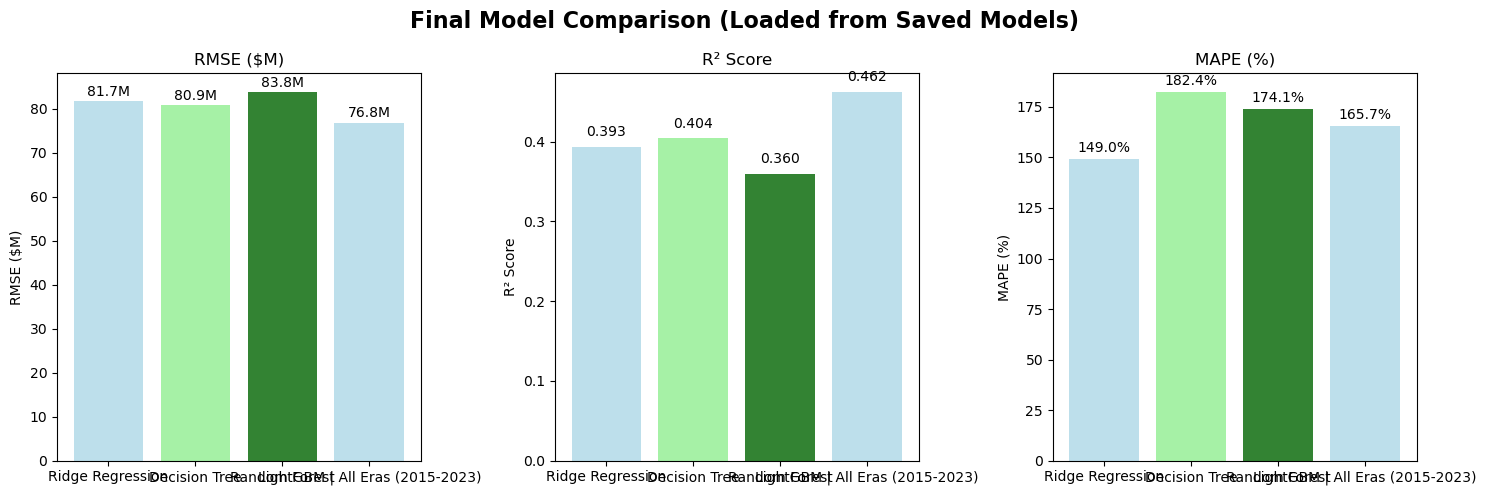

📊 Model comparison visualization complete


In [11]:
# Visualize model comparison
if len(available_results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Final Model Comparison (Loaded from Saved Models)', fontsize=16, fontweight='bold')

    models = [result['model_name'] for result in available_results]
    colors = ['lightblue', 'lightgreen', 'darkgreen'][:len(available_results)]

    # RMSE comparison
    rmse_values = [result['rmse']/1e6 for result in available_results]
    bars1 = axes[0].bar(models, rmse_values, color=colors, alpha=0.8)
    axes[0].set_title('RMSE ($M)')
    axes[0].set_ylabel('RMSE ($M)')
    for bar, val in zip(bars1, rmse_values):
        axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                    f'{val:.1f}M', ha='center', va='bottom')

    # R² comparison
    r2_values = [result['r2'] for result in available_results]
    bars2 = axes[1].bar(models, r2_values, color=colors, alpha=0.8)
    axes[1].set_title('R² Score')
    axes[1].set_ylabel('R² Score')
    for bar, val in zip(bars2, r2_values):
        axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{val:.3f}', ha='center', va='bottom')

    # MAPE comparison
    mape_values = [result['mape'] for result in available_results]
    bars3 = axes[2].bar(models, mape_values, color=colors, alpha=0.8)
    axes[2].set_title('MAPE (%)')
    axes[2].set_ylabel('MAPE (%)')
    for bar, val in zip(bars3, mape_values):
        axes[2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                    f'{val:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("📊 Model comparison visualization complete")
else:
    print("❌ No models available for visualization")

## 2024 Validation: Top 10 Predictions vs Actual

In [14]:

# Test best model on 2024 validation data
if len(available_results) > 0 and 'best_model' in globals():
    print("🎯 2024 Validation: Top 10 Predictions vs Actual")
    print("=" * 60)

    val_2024 = df[df['release_year'] == 2024].copy()
    if val_2024.empty:
        print("No 2024 validation data available")
    else:
        X_val_full = val_2024[feature_cols]
        preds_log = best_model.predict(X_val_full)
        val_2024['predicted_revenue'] = np.expm1(preds_log)

        ranking_metrics = compute_ranking_metrics(
            val_2024,
            val_2024['predicted_revenue'],
            target_col=target,
            title_col='title',
            k=10,
        )

        for result in available_results:
            if result.get('model_name') == best_model_result.get('model_name'):
                result.update(ranking_metrics)
                if result.get('top10_overlap') is not None:
                    result['top10_overlap'] = int(result['top10_overlap'])
        best_model_result.update(ranking_metrics)
        if best_model_result.get('top10_overlap') is not None:
            best_model_result['top10_overlap'] = int(best_model_result['top10_overlap'])

        top10_2024 = get_top10_predictions(best_model, df, 2024, feature_cols)

        if top10_2024 is not None:
            display_df = top10_2024.copy()
            display_df['predicted_revenue'] = display_df['predicted_revenue'].apply(lambda x: f"${x:,.0f}")
            if 'actual_revenue' in display_df.columns:
                display_df['actual_revenue'] = display_df['actual_revenue'].apply(lambda x: f"${x:,.0f}")
                display_df['prediction_error_pct'] = display_df['prediction_error_pct'].apply(lambda x: f"{x:+.1f}%")

            print(f"Top 10 Predicted vs Actual for 2024 ({best_model_result['model_name']}):")
            print(display_df.to_string(index=True))

            if 'actual_revenue' in top10_2024.columns:
                actual_top10 = val_2024.nlargest(10, target)['title'].tolist()
                predicted_top10 = top10_2024['title'].tolist()
                overlap = len(set(actual_top10) & set(predicted_top10))
                accuracy_pct = overlap / 10 * 100

                print("📈 2024 Validation Accuracy:")
                print(f"   Movies correctly predicted in top 10: {overlap}/10 ({accuracy_pct:.0f}%)")

                if ranking_metrics.get('recall_at_10') is not None:
                    print(f"   Recall@10: {ranking_metrics['recall_at_10']:.2%}")
                if ranking_metrics.get('precision_at_10') is not None:
                    print(f"   Precision@10: {ranking_metrics['precision_at_10']:.2%}")
                if ranking_metrics.get('ndcg_at_10') is not None:
                    print(f"   NDCG@10: {ranking_metrics['ndcg_at_10']:.3f}")
                if ranking_metrics.get('spearman_corr') is not None:
                    print(f"   Spearman correlation: {ranking_metrics['spearman_corr']:.3f}")
                if ranking_metrics.get('kendall_corr') is not None:
                    print(f"   Kendall correlation: {ranking_metrics['kendall_corr']:.3f}")

                if 'prediction_error_pct' in top10_2024.columns:
                    avg_error = top10_2024['prediction_error_pct'].abs().mean()
                    print(f"   Average prediction error: {avg_error:.1f}%")

                missed = set(actual_top10) - set(predicted_top10)
                false_positives = set(predicted_top10) - set(actual_top10)

                if missed:
                    print(f"❌ Missed (in actual top 10): {list(missed)}")
                if false_positives:
                    print(f"   ⚠️  False positives: {list(false_positives)}")
        else:
            print("No 2024 validation data available")
else:
    print("❌ No models available for validation testing")


🎯 2024 Validation: Top 10 Predictions vs Actual
Top 10 Predicted vs Actual for 2024 (LightGBM | All Eras (2015-2023)):
                               title predicted_revenue actual_revenue prediction_error_pct  is_marvel  is_dc  is_star_wars  is_superhero  is_sequel  is_live_action_remake  is_major_studio  is_disney
0              Mufasa: The Lion King      $353,909,531   $254,567,693               -39.0%          0      0             0             0          1                      1                1          1
1                            Moana 2      $282,818,687   $460,405,297               +38.6%          0      0             0             0          1                      1                1          1
2               Deadpool & Wolverine      $229,749,430   $636,745,858               +63.9%          1      0             0             1          1                      0                1          1
3               Sonic the Hedgehog 3      $228,879,182   $236,115,100                

## Feature Importance Analysis

In [15]:
# Analyze feature importance (for tree-based models)
if hasattr(best_model.named_steps, 'rf') or hasattr(best_model.named_steps, 'dt'):
    print("🔍 Feature Importance Analysis")
    print("=" * 50)
    
    # Get the model step
    if hasattr(best_model.named_steps, 'rf'):
        model_step = best_model.named_steps['rf']
    else:
        model_step = best_model.named_steps['dt']
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model_step.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Show top 15 features
    top_features = feature_importance.head(15)
    print("Top 15 Most Important Features:")
    print(top_features.to_string(index=False))
    
    # Visualize top 10 features
    plt.figure(figsize=(12, 6))
    top10_features = feature_importance.head(10)
    plt.barh(top10_features['feature'][::-1], top10_features['importance'][::-1], 
             color='darkgreen', alpha=0.7)
    plt.title(f'Top 10 Feature Importances ({best_model_result["model_name"]})')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Analyze alternative time features importance
    time_features = ['years_since_baseline', 'is_pre_streaming_era', 'is_streaming_transition', 
                    'is_pandemic_year', 'is_post_pandemic_era']
    
    print(f"\n🕒 Alternative Time Features Importance:")
    for feature in time_features:
        if feature in feature_importance['feature'].values:
            importance = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
            rank = list(feature_importance['feature']).index(feature) + 1
            print(f"   {feature}: {importance:.3f} (rank {rank})")
    
    total_time_importance = feature_importance[
        feature_importance['feature'].isin(time_features)
    ]['importance'].sum()
    print(f"\n   Total time features importance: {total_time_importance:.3f} ({total_time_importance*100:.1f}%)")
    
else:
    print("Feature importance not available for Ridge Regression")
    print("Ridge coefficients provide different interpretability")

Feature importance not available for Ridge Regression
Ridge coefficients provide different interpretability


## 2026 Predictions Ready!

In [ ]:

# Final summary and prediction readiness
print("🚀 READY FOR 2025/26 BOX OFFICE PREDICTIONS")
print("=" * 60)

if 'best_mlflow_run' in globals() and 'best_model_result' in globals():
    best_run_name = best_model_result.get('model_name', 'MLflow run')
    best_run_rmse = best_model_result.get('rmse', float('nan'))
    best_run_r2 = best_model_result.get('r2', float('nan'))
    studio_scope = best_mlflow_run.get('data_scope_studios') or best_mlflow_run.get('tag_studio_scope')
    language_scope = best_mlflow_run.get('data_scope_language') or best_mlflow_run.get('tag_language_scope')
    scope_parts = []
    if studio_scope and studio_scope != 'unknown':
        scope_parts.append(f"studios: {studio_scope}")
    if language_scope and language_scope != 'unknown':
        scope_parts.append(f"language: {language_scope}")
    scope_text = f" ({', '.join(scope_parts)})" if scope_parts else ''
    top10_overlap_value = best_model_result.get('top10_overlap')
    top10_text = f", Top-10 overlap {top10_overlap_value}/10" if top10_overlap_value is not None else ''
    recall_value = best_model_result.get('recall_at_10')
    recall_text = f", Recall@10 {recall_value:.2%}" if recall_value is not None else ''
    precision_value = best_model_result.get('precision_at_10')
    precision_text = f", Precision@10 {precision_value:.2%}" if precision_value is not None else ''
    ndcg_value = best_model_result.get('ndcg_at_10')
    ndcg_text = f", NDCG@10 {ndcg_value:.3f}" if ndcg_value is not None else ''
    corr_parts = []
    if best_model_result.get('spearman_corr') is not None:
        corr_parts.append(f"Spearman {best_model_result['spearman_corr']:.3f}")
    if best_model_result.get('kendall_corr') is not None:
        corr_parts.append(f"Kendall {best_model_result['kendall_corr']:.3f}")
    corr_text = f", {' | '.join(corr_parts)}" if corr_parts else ''
    rmse_text = f"${best_run_rmse:,.0f}" if pd.notna(best_run_rmse) else 'n/a'
    r2_text = f"{best_run_r2:.3f}" if pd.notna(best_run_r2) else 'n/a'
    print(f"🏅 Best MLflow Run: {best_run_name}{scope_text} (RMSE {rmse_text}, R² {r2_text}{top10_text}{recall_text}{precision_text}{ndcg_text}{corr_text})")

print(f"✅ Best Model Selected: {best_model_result['model_name']}")
print(f"   • Validation RMSE: ${best_model_result['rmse']:,.0f}")
print(f"   • Validation R²: {best_model_result['r2']:.3f}")
print(f"   • Validation MAPE: {best_model_result['mape']:.1f}%")
if best_model_result.get('top10_overlap') is not None:
    print(f"   • Top-10 overlap: {best_model_result['top10_overlap']}/10")
if best_model_result.get('recall_at_10') is not None:
    print(f"   • Recall@10: {best_model_result['recall_at_10']:.2%}")
if best_model_result.get('precision_at_10') is not None:
    print(f"   • Precision@10: {best_model_result['precision_at_10']:.2%}")
if best_model_result.get('ndcg_at_10') is not None:
    print(f"   • NDCG@10: {best_model_result['ndcg_at_10']:.3f}")
if best_model_result.get('spearman_corr') is not None:
    print(f"   • Spearman correlation: {best_model_result['spearman_corr']:.3f}")
if best_model_result.get('kendall_corr') is not None:
    print(f"   • Kendall correlation: {best_model_result['kendall_corr']:.3f}")

if 'DATA_SCOPE' in globals():
    print("   • Dataset scope:")
    print(f"       - Studio: {DATA_SCOPE.get('studio_note', 'all studios')}")
    print(f"       - Language: {DATA_SCOPE.get('language_note', 'all languages')}")

print("📊 Model Performance Summary:")
dedup_results = []
seen_names = set()
for res in available_results:
    name = res['model_name']
    if name in seen_names:
        continue
    seen_names.add(name)
    dedup_results.append(res)
for i, result in enumerate(dedup_results, 1):
    line = f"   {i}. {result['model_name']}: RMSE ${result['rmse']:,.0f}, R² {result['r2']:.3f}"
    if result.get('top10_overlap') is not None:
        line += f", Top-10 overlap {int(result['top10_overlap'])}/10"
    if result.get('recall_at_10') is not None:
        line += f", Recall@10 {result['recall_at_10']:.2%}"
    if result.get('precision_at_10') is not None:
        line += f", Precision@10 {result['precision_at_10']:.2%}"
    if result.get('ndcg_at_10') is not None:
        line += f", NDCG@10 {result['ndcg_at_10']:.3f}"
    if result.get('spearman_corr') is not None:
        line += f", Spearman {result['spearman_corr']:.3f}"
    if result.get('kendall_corr') is not None:
        line += f", Kendall {result['kendall_corr']:.3f}"
    print(line)


🚀 READY FOR 2026 BOX OFFICE PREDICTIONS
🏅 Best MLflow Run: LightGBM | All Eras (2015-2023) (studios: all_studios, language: english_only) (RMSE $76,828,355, R² 0.462, Top-10 overlap 7/10)
✅ Best Model Selected: LightGBM | All Eras (2015-2023)
   • Validation RMSE: $76,828,355
   • Validation R²: 0.462
   • Validation MAPE: 165.7%
   • Top-10 overlap: 7/10
   • Recall@10: 70.00%
   • NDCG@10: 0.739
   • Spearman correlation: 0.683
   • Kendall correlation: 0.493
✅ Safe for 2026 Predictions:
   • Uses alternative time features (no data leakage)
   • Focused on major studio films
   • Weighted training handles pandemic impact
   • Temporal validation on 2024 data
🎯 2026 Feature Values:
   • years_since_baseline: 11 (safe extrapolation)
   • is_post_pandemic_era: 1 (reasonable assumption)
   • All other era flags: 0
📊 Model Performance Summary:
   1. Ridge Regression: RMSE $81,662,172, R² 0.393
   2. Decision Tree: RMSE $80,903,869, R² 0.404
   3. Random Forest: RMSE $83,841,416, R² 0.360
